###  Truncated Cauchy Non-Negative Matrix Factorization (NMF).
Reference: Guan, N., Liu, T., Zhang, Y., Tao, D., & Davis, L. S. (2017). Truncated Cauchy non-negative matrix factorization. IEEE Transactions on pattern analysis and machine intelligence, 41(1), 246-259. 

Implemented using Nesterov-based Half-Quadratic Programming. This function takes the following main inputs:

	•	V: The data matrix, where each column represents a sample.
	•	r: The number of basis vectors (i.e., the target lower dimension).

This function likely performs matrix factorization on V to approximate it as the product of two matrices, W (basis matrix) and H (coefficient matrix).

1.	Iteration Control: \
    •	MAX_ITER: Maximum number of iterations. \
    •	MIN_ITER: Minimum number of iterations. \
    •	MAX_TIME: Maximum runtime allowed. 
2.	Algorithm Type (ALG_TYPE): \
    •	Options include ‘OGM’ (Optimal Gradient Method), ‘MUR’ (Multiplicative Update Rule), ‘HALS’ (Weighted Hierarchical Alternating Least Squares), and ‘BCD’ (Block Coordinate Descent). These are optimization algorithms used to solve the matrix factorization problem. 
3.	Weighting Type (WEI_TYPE): \
    •	Options like ‘plain’, ‘tgv’, ‘tlv’, ‘mrf’, and ‘med’ specify different methods for weighting, with some designed for robustness, such as trimming outliers or using median filtering.

In [32]:
import numpy as np
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

In [71]:

def truncated_cauchy_nmf_channel(V, rank, max_iter, tol, gamma):
    """
    Apply Truncated Cauchy NMF to a single color channel.
    
    Parameters:
        V (numpy.ndarray): Input matrix for one color channel.
        rank (int): Target rank for the low-rank approximation.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.
        gamma (float): Scale parameter for Truncated Cauchy loss.
        
    Returns:
        numpy.ndarray: Denoised matrix for the color channel.
    """
    m, n = V.shape
    W = np.abs(np.random.rand(m, rank))
    H = np.abs(np.random.rand(rank, n))
    
    for iteration in range(max_iter):
        # Calculate the current reconstruction and residual
        V_approx = np.dot(W, H)
        residual = V - V_approx
        
        # Update H using non-negative least squares
        H_update = np.dot(W.T, V) / (np.dot(W.T, np.dot(W, H)) + gamma)
        H = np.maximum(H * H_update, 1e-10)  # Ensuring non-negativity

        # Update W using non-negative least squares
        W_update = np.dot(V, H.T) / (np.dot(W, np.dot(H, H.T)) + gamma)
        W = np.maximum(W * W_update, 1e-10)  # Ensuring non-negativity

        # Calculate the Frobenius norm of the residual for convergence
        error = np.linalg.norm(residual, 'fro')
        if error < tol:
            break

    return np.dot(W, H)

def truncated_cauchy_nmf_color(image_path, output_path, max_iter, tol, gamma, downsample_factor):
    """
    Apply Truncated Cauchy NMF to each color channel of an image and save the denoised result.
    
    Parameters:
        image_path (str): Path to the input facade image.
        output_path (str): Path to save the denoised image.
        rank (int): Target rank for low-rank approximation.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.
        gamma (float): Scale parameter for Truncated Cauchy loss.
        downsample_factor (int): Factor to downsample the image for faster processing.
        
    Returns:
        None: The denoised image is saved at the specified output path.
    """
    # Load and downsample the image
    image = Image.open(image_path).convert("RGB")
    image = image.resize((image.width // downsample_factor, image.height // downsample_factor), Image.LANCZOS)
    
    # Split the image into RGB channels
    R, G, B = image.split()
    R = np.asarray(R, dtype=np.float32) / 255
    G = np.asarray(G, dtype=np.float32) / 255
    B = np.asarray(B, dtype=np.float32) / 255

    # Apply Truncated Cauchy NMF on each channel separately
    R_denoised = truncated_cauchy_nmf_channel(R, rank, max_iter, tol, gamma)
    G_denoised = truncated_cauchy_nmf_channel(G, rank, max_iter, tol, gamma)
    B_denoised = truncated_cauchy_nmf_channel(B, rank, max_iter, tol, gamma)

    # Clip values to [0, 1] range and convert back to 8-bit
    R_denoised = np.clip(R_denoised, 0, 1) * 255
    G_denoised = np.clip(G_denoised, 0, 1) * 255
    B_denoised = np.clip(B_denoised, 0, 1) * 255

    # Recombine channels into a single color image
    R_img = Image.fromarray(R_denoised.astype(np.uint8))
    G_img = Image.fromarray(G_denoised.astype(np.uint8))
    B_img = Image.fromarray(B_denoised.astype(np.uint8))
    denoised_image = Image.merge("RGB", (R_img, G_img, B_img))
    
    # Apply a slight sharpening filter for edge enhancement
    # denoised_image = denoised_image.filter(ImageFilter.SHARPEN)
    denoised_image = denoised_image.filter(ImageFilter.DETAIL)

    # Save the denoised image
    denoised_image.save(output_path)
    print(f"Denoised image saved at {output_path}")
    return image, denoised_image

# Visualization function
def visualize_denoising(image_path, output_path, index):
    original_image, denoised_image = truncated_cauchy_nmf_color(image_path, output_path)
    
    # Display both images side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Denoised Image")
    plt.imshow(denoised_image)
    plt.axis("off")

    plt.savefig("data/incomplete_facades/comparison/" + str(index))
    plt.show()


Denoised image saved at data/incomplete_facades/denoised_images/101_[uid_3194]_.png


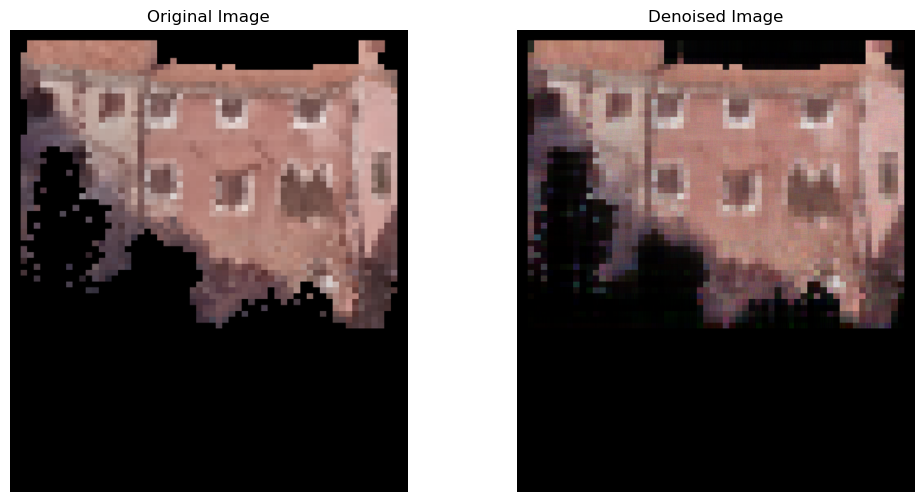

In [50]:
image_name = '101_[uid_3194]_.png'
input_path = 'data/incomplete_facades/images/' + image_name   
output_path = 'data/incomplete_facades/denoised_images/' + image_name  

# truncated_cauchy_nmf_color(input_path, output_path, rank=10)
visualize_denoising(input_path, output_path, 1)

### process in batch

Denoised image saved at data/incomplete_facades/denoised_images/denoised_2353_[uid_1219]_.png


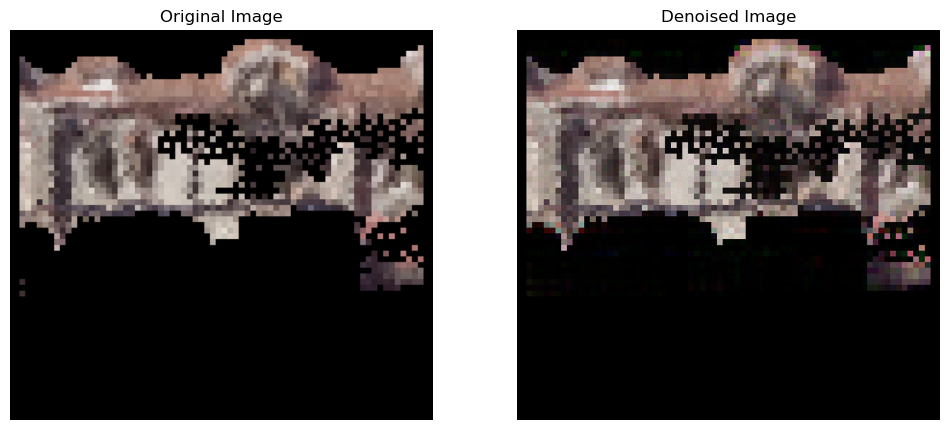

Denoised image saved at data/incomplete_facades/denoised_images/denoised_2045_[uid_3464]_.png


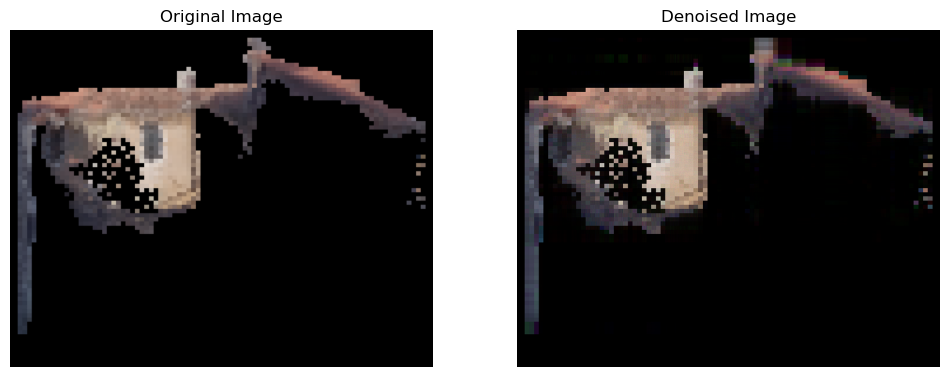

Denoised image saved at data/incomplete_facades/denoised_images/denoised_7466_[uid_2870]_.png


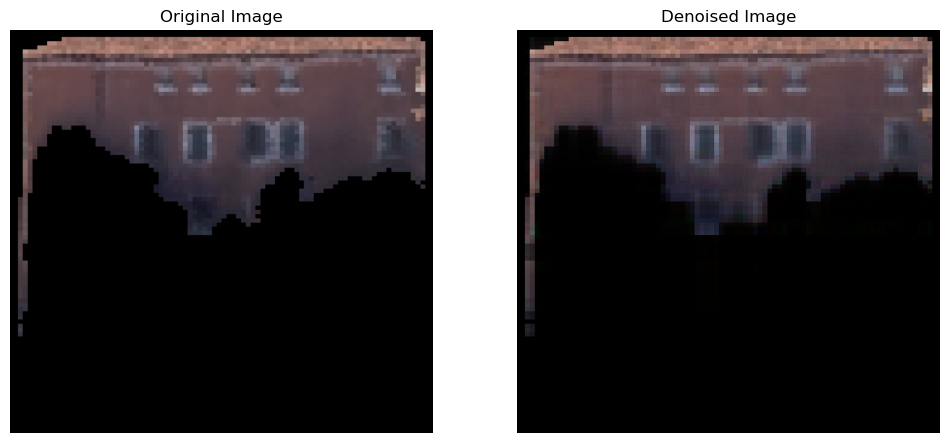

Denoised image saved at data/incomplete_facades/denoised_images/denoised_7967_[uid_0524]_.png


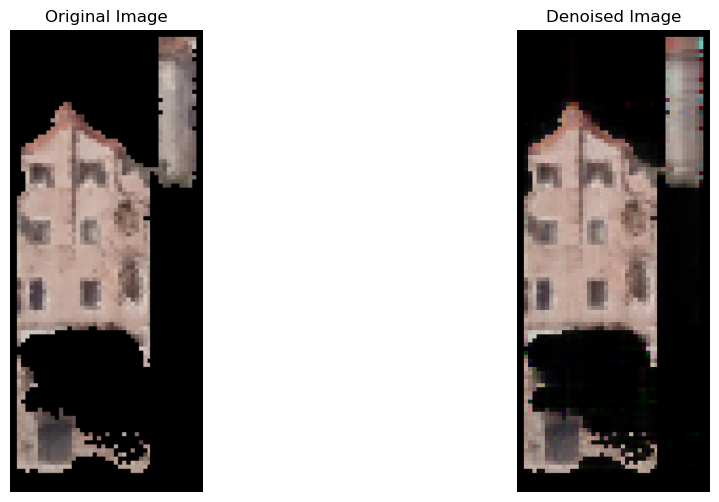

Denoised image saved at data/incomplete_facades/denoised_images/denoised_4346_[uid_2183]_.png


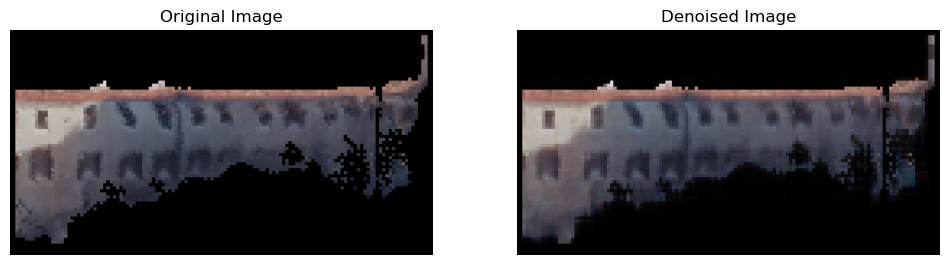

Denoised image saved at data/incomplete_facades/denoised_images/denoised_3131_[uid_2533]_.png


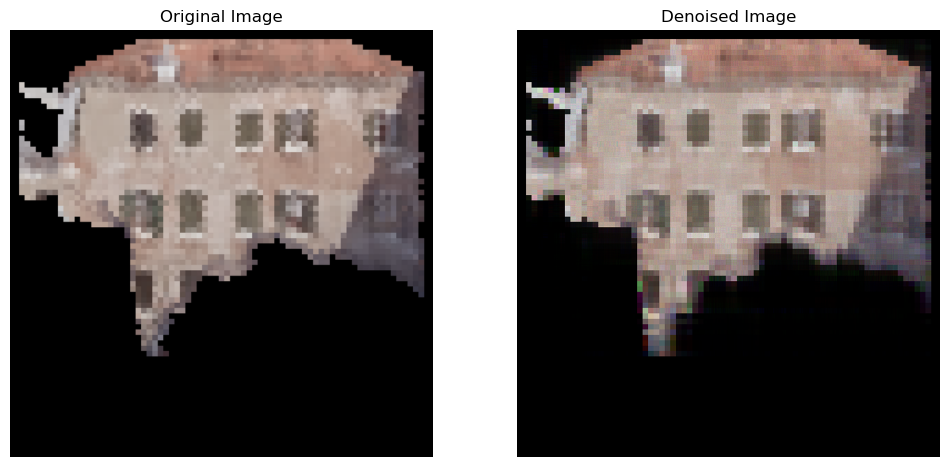

process finished


In [76]:
# parameters to be adjusted.
rank=50
max_iter=50
tol=1e-3
gamma=0.01
downsample_factor=2

def process_images_in_folder(folder_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    # Get list of image files in the folder and select the first 10
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[50:56]
    
    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        # image = Image.open(image_path).convert("RGB")
        output_path = os.path.join(output_folder, f"denoised_{image_file}")
        # Apply Truncated Cauchy NMF denoising
        # denoised_image = truncated_cauchy_nmf_color(image_path, output_path)
        visualize_denoising(image_path, output_path, image_file)
        # denoised_image.save(output_path)
    print("process finished")

folder_path = 'data/incomplete_facades/images/'        # Replace with the path to your folder containing images
output_folder = 'data/incomplete_facades/denoised_images/'    # Replace with the path to your output folder
process_images_in_folder(folder_path, output_folder)